In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import regularizers

In [2]:
# Load data
stocks_data = pd.read_pickle('current_data/nsx100_10y.pkl')
index_data = pd.read_pickle('current_data/nsx100_index_10y.pkl')
assets_names = stocks_data.columns.values

data_assets = stocks_data
data_index = index_data

print("Stocks data (time series) shape: {shape}".format(shape=stocks_data.shape))
print("Index data (time series) shape: {shape}".format(shape=index_data.shape))

stocks_data.head()

Stocks data (time series) shape: (253, 101)
Index data (time series) shape: (253,)


,ATVI,ADBE,AMD,ABNB,ALGN,GOOGL,GOOG,AMZN,AEP,AMGN,...,TXN,VRSN,VRSK,VRTX,WBA,WDAY,XEL,XLNX,ZM,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-30,91.138718,497.450012,92.290001,148.429993,524.320007,1736.250000,1739.520020,3285.850098,78.685181,220.353027,...,158.960602,214.500000,204.539963,232.679993,37.892834,236.929993,63.854073,141.834656,353.399994,201.309998
2020-12-31,92.402596,500.119995,91.709999,146.800003,534.380005,1752.640015,1751.880005,3256.929932,80.384186,223.020477,...,160.357758,216.399994,206.339066,236.339996,38.412971,239.610001,64.846153,141.505264,337.320007,199.710007
2021-01-04,89.466812,485.339996,92.300003,139.149994,526.460022,1726.130005,1728.239990,3186.629883,78.714142,219.858322,...,158.491638,213.580002,201.657471,229.429993,39.877052,228.080002,63.863796,142.164032,359.980011,196.089996
2021-01-05,90.253006,485.690002,92.769997,148.300003,543.650024,1740.050049,1740.920044,3218.510010,78.607956,220.925308,...,159.654282,206.500000,200.752945,228.580002,39.645882,225.360001,63.241299,143.960663,360.829987,193.479996
2021-01-06,87.575966,466.309998,90.330002,142.770004,540.390015,1722.880005,1735.290039,3138.379883,79.235428,226.250565,...,160.445679,199.509995,198.854446,226.649994,41.447094,220.000000,64.641907,140.956299,344.410004,184.419998


In [3]:
# Split data
n_train = int(data_assets.shape[0]*0.8)

# Stocks data
X_train = data_assets.values[:n_train, :]
X_test = data_assets.values[n_train:, :]

# Index data
index_train = data_index[:n_train]
index_test = data_index[n_train:]

In [4]:
# Normalize data
scaler = MinMaxScaler([0, 1])
# Stocks data
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
# Index data
scaler_index = MinMaxScaler([0, 1])
index_train = scaler_index.fit_transform(index_train[:, np.newaxis])
index_test = scaler_index.fit_transform(index_test[:, np.newaxis])

/opt/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/opt/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':


In [5]:
## Autoencoder - Keras

# Network hyperparameters
n_inputs = X_train.shape[1]

# Training hyperparameters
epochs = 50
batch_size = 1

# Define model
input = Input(shape=(n_inputs,))
# Encoder Layers
encoded = Dense(4, input_shape=(n_inputs,), activation='relu')(input)
decoded = Dense(n_inputs, activation='sigmoid')(encoded)

# Encoder
encoder = Model(input, encoded)

# Autoencoder
model = Model(input, decoded)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 101)]             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 408       
_________________________________________________________________
dense_1 (Dense)              (None, 101)               505       
Total params: 913
Trainable params: 913
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Compile the model
model.compile(loss='mse', optimizer='adam')

In [7]:
# Fit the model
history = model.fit(X_train,
                    X_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=0
                    )

In [8]:
# List all data recorded in history
print(history.history.keys())

dict_keys(['loss'])


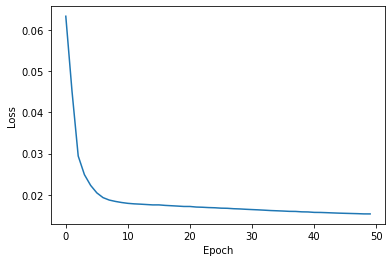

In [9]:
# Visualize training loss
plt.figure()
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
#plt.savefig('images/vanillaAE_loss.png', bbox_inches='tight')

In [10]:
#from keras.models import model_from_json

## Save model
## serialize model to JSON
#model_json = model.to_json()
#with open("models/vanillaAE_model.json", "w") as json_file:
#    json_file.write(model_json)
## serialize weights to HDF5
#model.save_weights("models/vanillaAE_model.h5")

In [11]:
## Load model
## load json and create model
#json_file = open('models/vanillaAE_model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#model = model_from_json(loaded_model_json)
## load weights into new model
#model.load_weights("models/vanillaAE_model.h5")

In [12]:
# Evaluate model
score_train = model.evaluate(X_train, X_train, batch_size=batch_size)
score_test = model.evaluate(X_test, X_test, batch_size=batch_size)

print('Training MSE: %.8f' %score_train)
print('Training MSE: %.8f' %score_test)

51/51 [==============================] - 0s 779us/step - loss: 0.0753
Training MSE: 0.01513537
Training MSE: 0.07532545


In [13]:
# Obtain reconstruction of the stocks
X_train_pred = model.predict(X_train)
X_test_pred = model.predict(X_test)

# Reconstruction error
error_train = np.mean(np.abs(X_train - X_train_pred)**2, axis=0)
print('Training MSE: %.8f' %np.mean(error_train))

error_test = np.mean(np.abs(X_test - X_test_pred)**2, axis=0)
print('Testing MSE: %.8f' %np.mean(error_test))

Training MSE: 0.01513537
Testing MSE: 0.07532545


In [14]:
# Sort stocks by reconstruction error
ind = np.argsort(error_train)
sort_error = error_train[ind]
sort_assets_names = assets_names[ind]

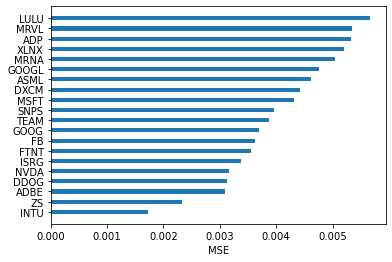

In [15]:
# Barplot
plt.figure()
plt.barh(2*np.arange(len(error_train[:20])), error_train[ind[:20]], tick_label=assets_names[ind[:20]])
plt.xlabel('MSE')
plt.show()
#plt.savefig('images/vanillaAE_MSEbar.png', bbox_inches='tight')

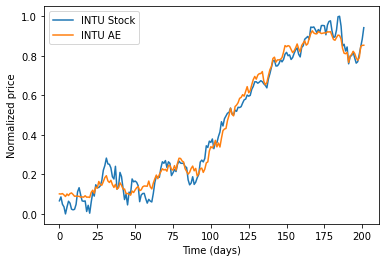

In [28]:
# Plot stock
i = 0
plt.figure()
plt.plot(X_train[:, ind[i]], label=assets_names[ind[i]] + ' Stock')
plt.plot(X_train_pred[:, ind[i]], label=assets_names[ind[i]] + ' AE')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()
#plt.savefig('images/vanillaAE_' + assets_names[ind[i]] + '.png', bbox_inches='tight')

In [17]:
# Identify stocks
n = 5

portfolio_train = X_train_pred[:, ind[:n]]
portfolio_test = X_test_pred[:, ind[:n]]

# Create portfolio in-sample
tracked_index_insample = np.mean(portfolio_train, axis=1)

# Create portfolio out-sample
tracked_index_outofsample = np.mean(portfolio_test, axis=1)

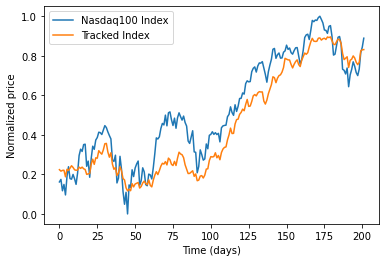

In [18]:
# In-sample
plt.figure()
plt.plot(index_train, label='Nasdaq100 Index')
plt.plot(tracked_index_insample, label='Tracked Index')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()
#plt.savefig('images/vanillaAE_insample.png', bbox_inches='tight')

In [19]:
# Correlation coefficient (in-sample)
corr_train = np.corrcoef(index_train.squeeze(), tracked_index_insample)[0, 1]
print('Correlation coefficient (in-sample): %.8f' %corr_train)

Correlation coefficient (in-sample): 0.95583108


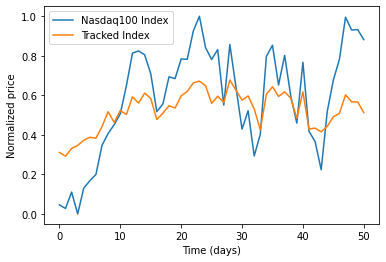

In [20]:
# Plot tracked index (out-of-sample)
plt.figure()
plt.plot(index_test, label='Nasdaq100 Index')
plt.plot(tracked_index_outofsample, label='Tracked Index')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()
#plt.savefig('images/vanillaAE_outofsample.png', bbox_inches='tight')

In [21]:
# Correlation coefficient (out-of-sample)
corr_test = np.corrcoef(index_test.squeeze(), tracked_index_outofsample)[0, 1]
print('Correlation coefficient: %.8f' %corr_test)

Correlation coefficient: 0.87635733


In [22]:
# Predict code values
code_values = encoder.predict(X_test)
#code_values.save('models/vanillaAE_code.npy')

# Compute mean
mean_code = np.mean(code_values, axis=(0, 1))
print('Mean of code values for vanilla AE: %.8f' %mean_code)

Mean of code values for vanilla AE: 1.89480293
